In [184]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline
import matplotlib.image as img
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score, mean_squared_error
from bayes_opt import BayesianOptimization
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

In [2]:
#loading the dataset
df=pd.read_csv('~/Desktop/Polyfins/Polyfins-Internship23-BD/Rifatul_Islam/Task2/housing.csv')

# EDA

In [3]:
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

### Meaning of the features
* 1. longitude: A measure of how far west a house is; a higher value is farther west
* 2. latitude: A measure of how far north a house is; a higher value is farther north
* 3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
* 4. totalRooms: Total number of rooms within a block
* 5. totalBedrooms: Total number of bedrooms within a block
* 6. population: Total number of people residing within a block
* 7. households: Total number of households, a group of people residing within a home unit, for a block
* 8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
* 9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
* 10. oceanProximity: Location of the house w.r.t ocean/sea

In [4]:
df.shape

(20640, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Except from ocean_proximity(object), all are float type.

In [6]:
ocean_values=df.ocean_proximity.value_counts()
ocean_values

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
ocean_values.index

Index(['<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND'], dtype='object')

The "ocean_proximity" feature is likely to be a useful categorical variable for understanding the spatial distribution of houses in the dataset and might have an impact on the median house value, as houses close to the ocean or in coastal areas tend to have different property values compared to houses located further inland.

* <1H OCEAN: Houses located less than 1 hour away from the ocean. This could include coastal areas close to the ocean.

* INLAND: Houses located inland, away from the coastline or any large bodies of water.

* NEAR OCEAN: Houses located near the ocean but not necessarily within an hour's distance. This category might include areas relatively close to the ocean.

* NEAR BAY: Houses located near a bay or an inlet of the ocean.

* ISLAND: Houses located on an island. This category could represent houses that are situated on isolated land surrounded by water.

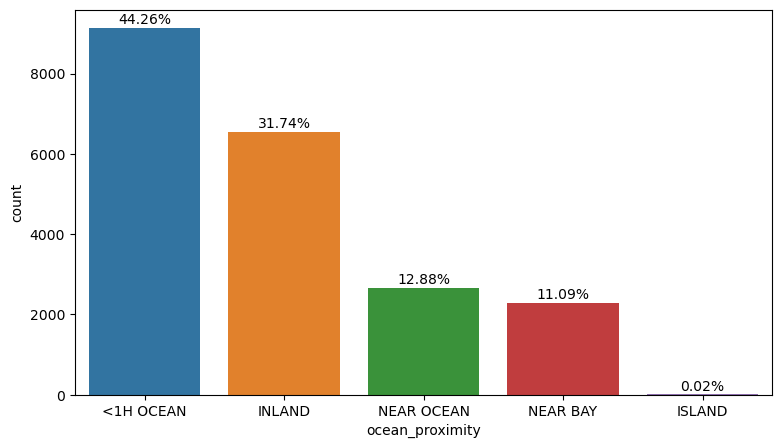

In [8]:
plt.figure(figsize=(9,5))
sns.countplot(x = "ocean_proximity",data=df,order=ocean_values.index)

# showing the percenotge
for i in range(ocean_values.shape[0]):
    count = ocean_values[i] 
    pct='{:0.2f}%'.format(100*count / df.shape[0]) 
    plt.text(i, count+100, pct, ha='center', color='black', fontsize=10) 

In [9]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

<Axes: >

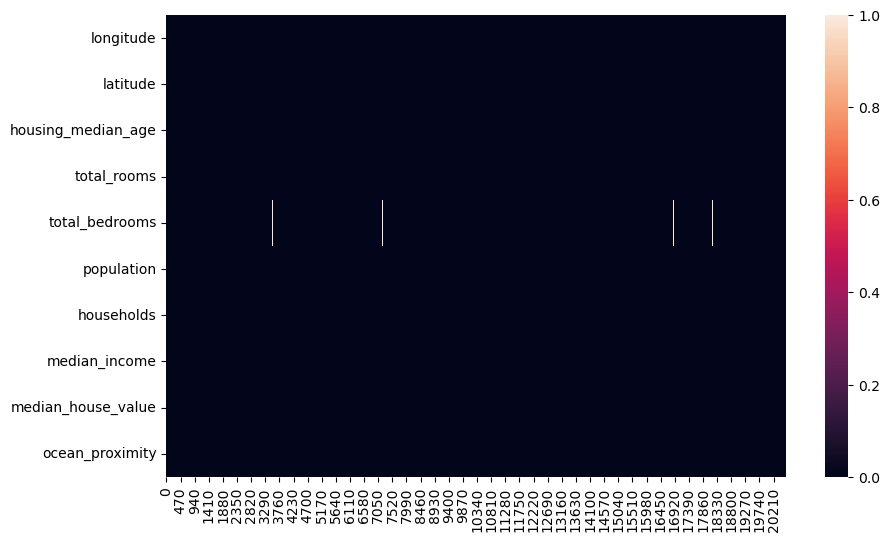

In [38]:
#Showing missing data with heatmap 
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose())

In [11]:
df.describe() #several statistics of the numerical columns

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

<Figure size 640x480 with 0 Axes>

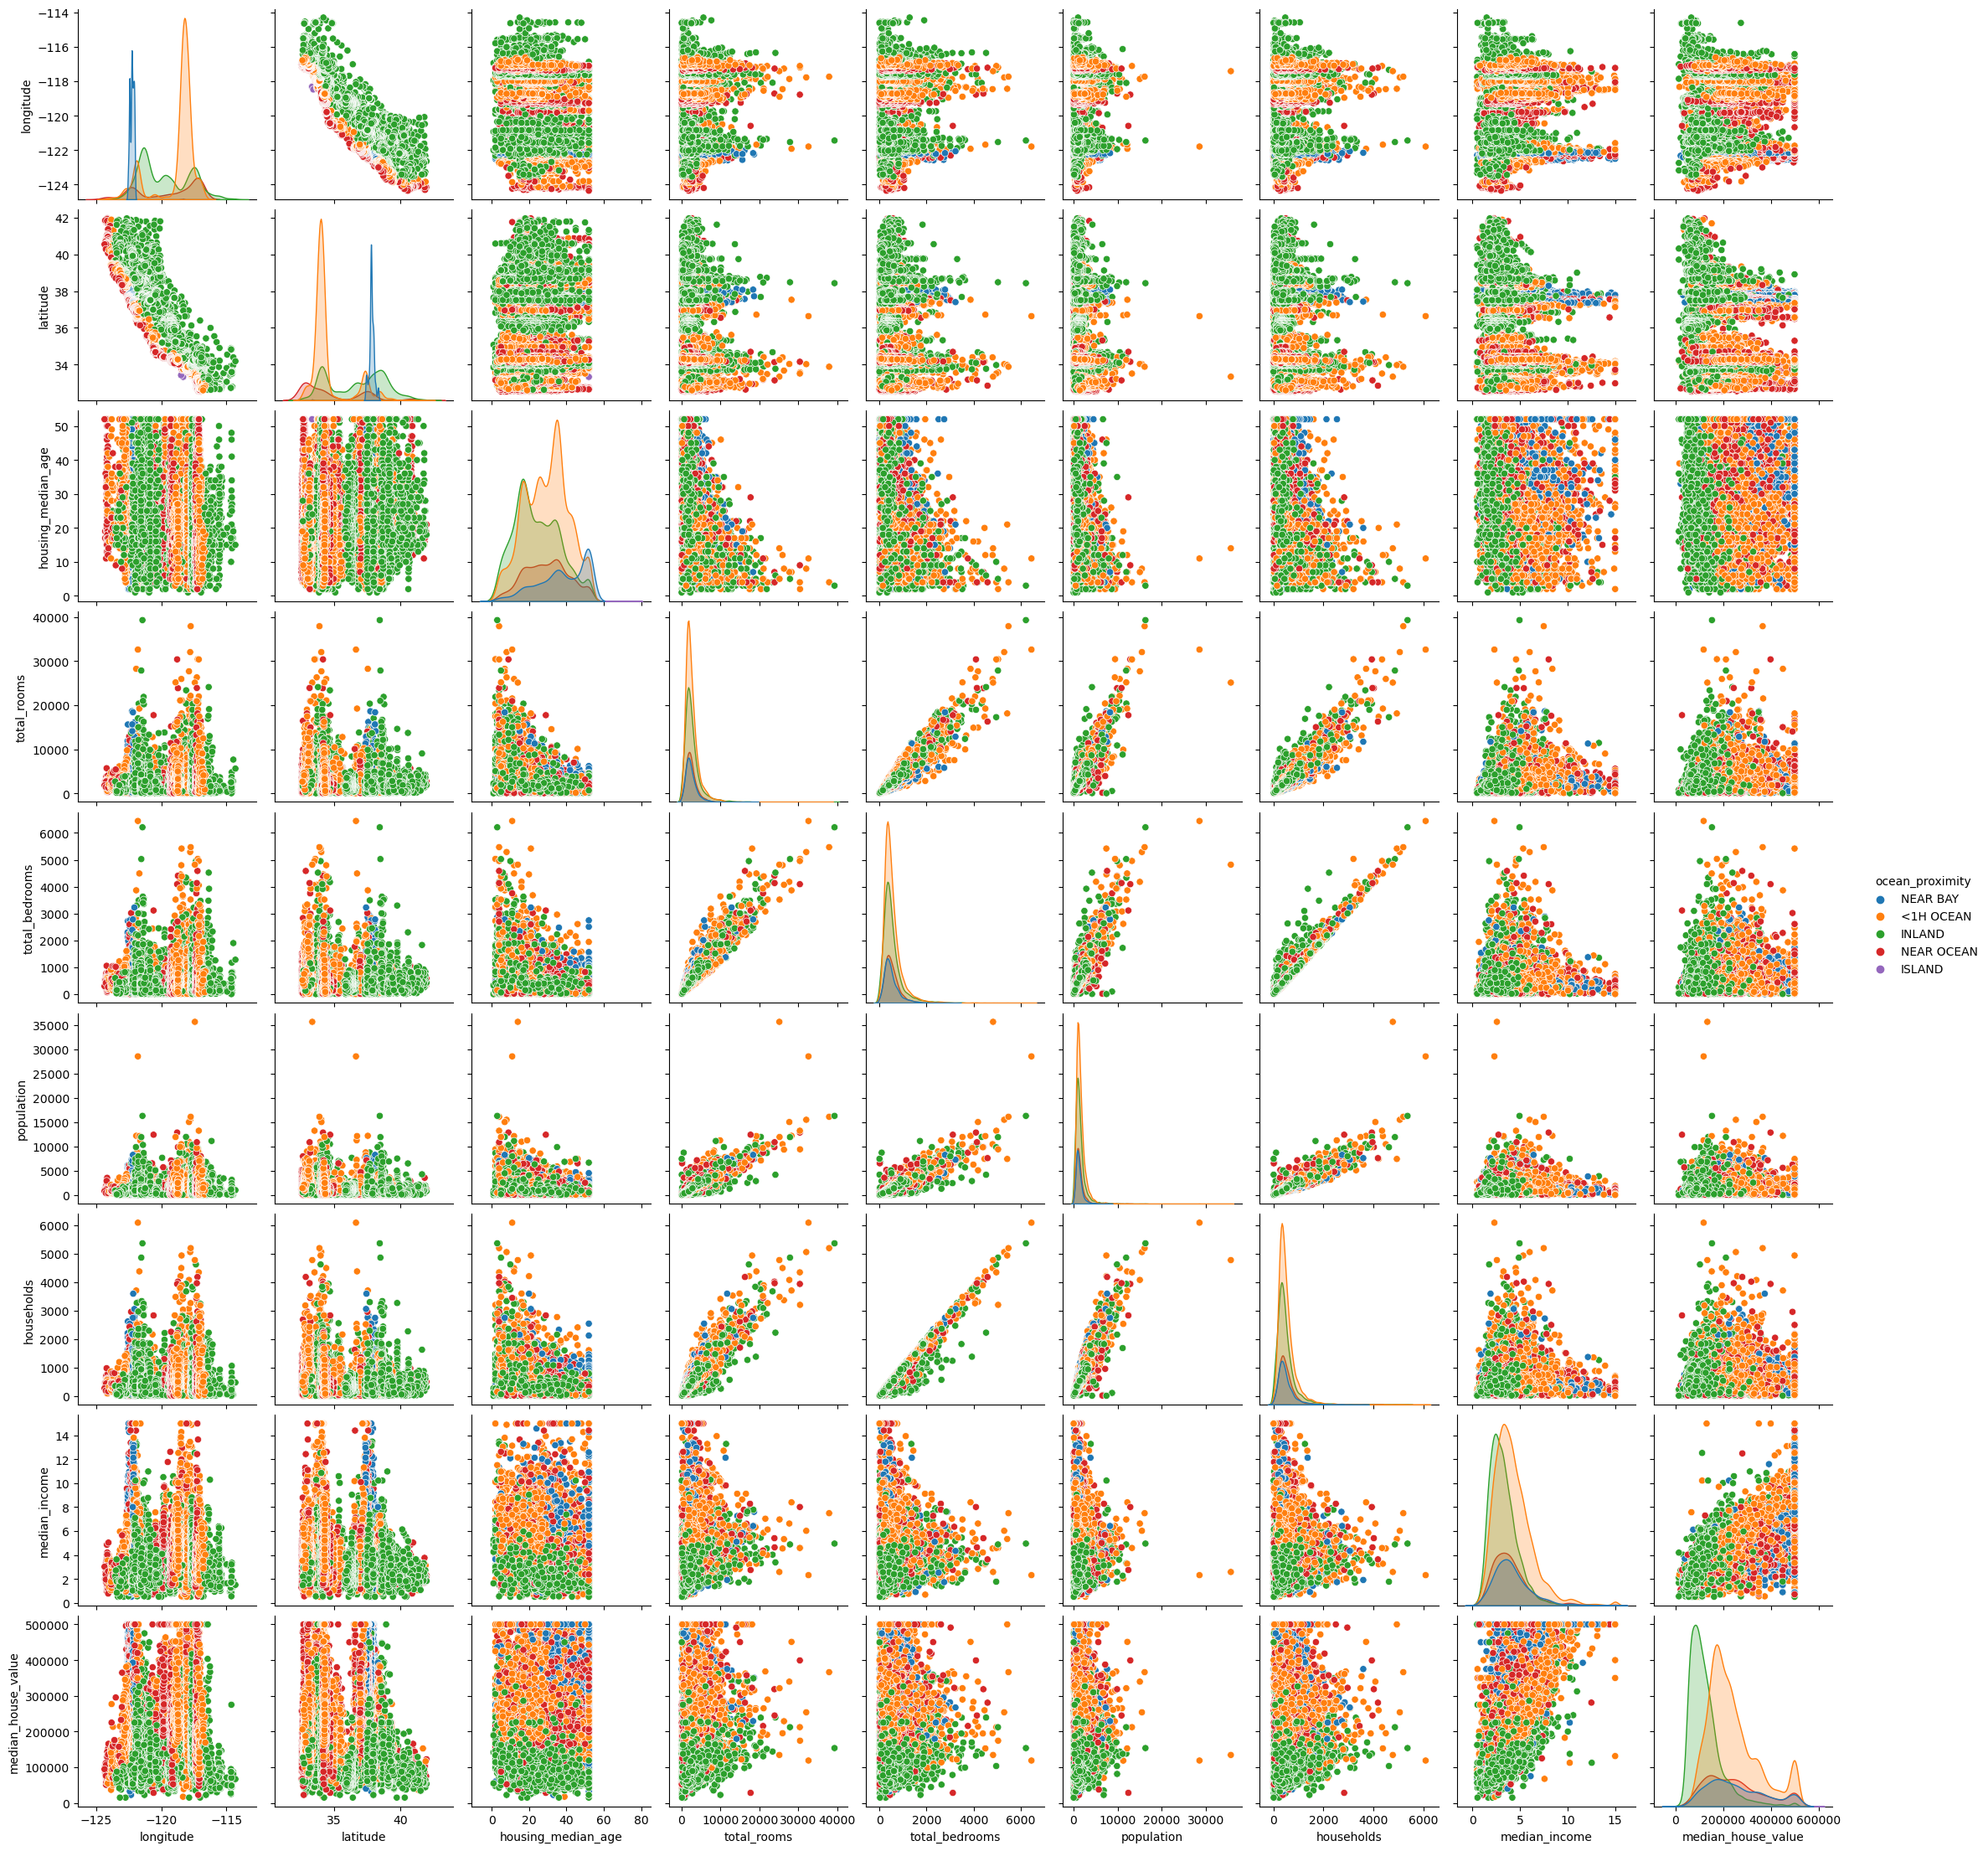

In [12]:
#Pairwise relationship among features for each ocean_proximity category
plt.figure()
sns.pairplot(df,hue='ocean_proximity')
plt.show()

<Axes: xlabel='median_income', ylabel='median_house_value'>

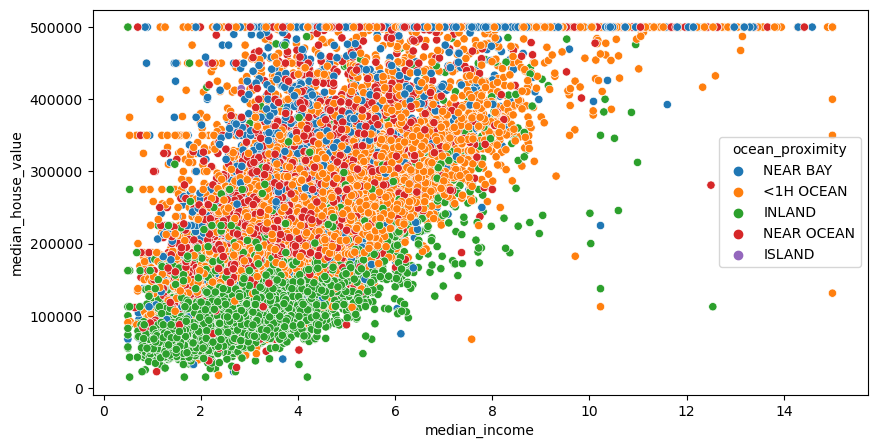

In [13]:
#showing relation between median_income and median_house value (also demonstrated in the above plot)
plt.figure(figsize=(10,5))
sns.scatterplot(data=df,x='median_income',y='median_house_value', hue='ocean_proximity')

<Axes: xlabel='ocean_proximity', ylabel='median_house_value'>

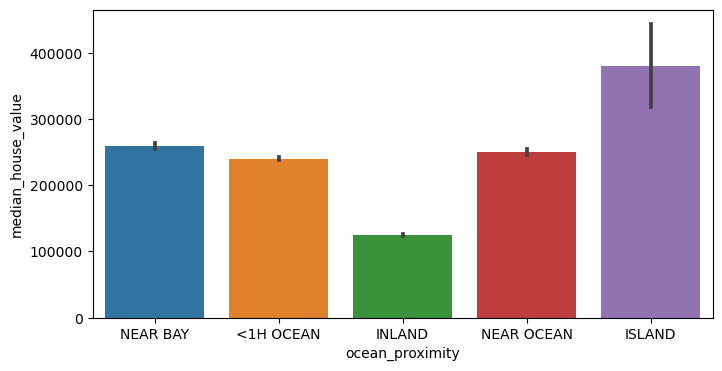

In [14]:
#median_house_value for different distances from ocean
plt.figure(figsize=(8,4))
sns.barplot(data=df,x='ocean_proximity',y='median_house_value')

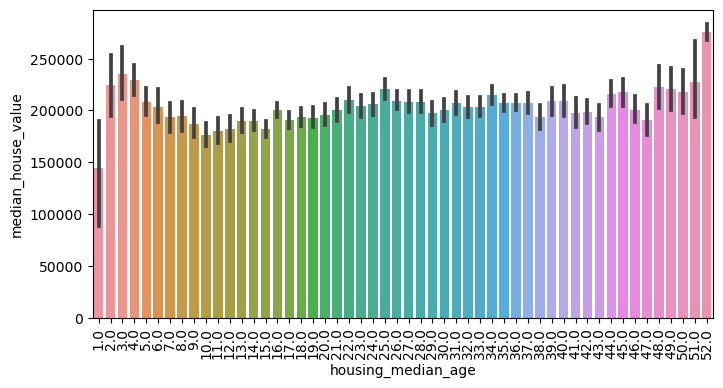

In [16]:
plt.figure(figsize=(8,4))
sns.barplot(data=df,x='housing_median_age',y='median_house_value')

plt.xticks(rotation=90)
plt.show()

In [17]:
#illustrating geo map of california region
import folium as folium
from folium import plugins
from folium.plugins import HeatMap
california_map = folium.Map(location=[36.7783,-119.4179],zoom_start=6, min_zoom=6, max_zoom=6)
#geographical coordinates [36.7783, -119.4179], representing the location of California. 
                            
df_map = df[['latitude', 'longitude']]
data = [[row['latitude'],row['longitude']] for index, row in df_map.iterrows()]
_ = HeatMap(data, radius=10).add_to(california_map)

california_map

<Figure size 1000x700 with 0 Axes>

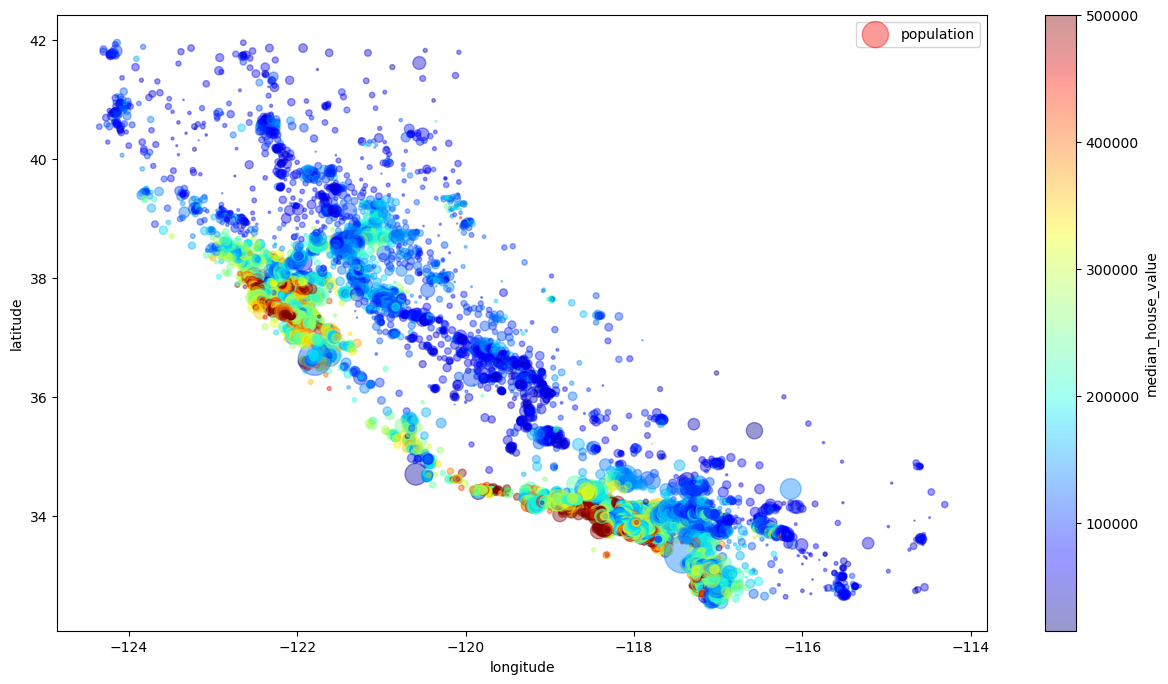

In [18]:
plt.figure(figsize=(10,7));
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=df["population"]/50, label="population", 
        figsize=(15,8),  #population is scaled down so that it is visible and distinguishable.
        c="median_house_value", cmap=plt.get_cmap("jet"),colorbar=True);
plt.legend();


Here, the larger the circle, the larger the population. Besides, we can see in near the ocean (on left), house prices are comparatively higher (red, yellow, green circles). 

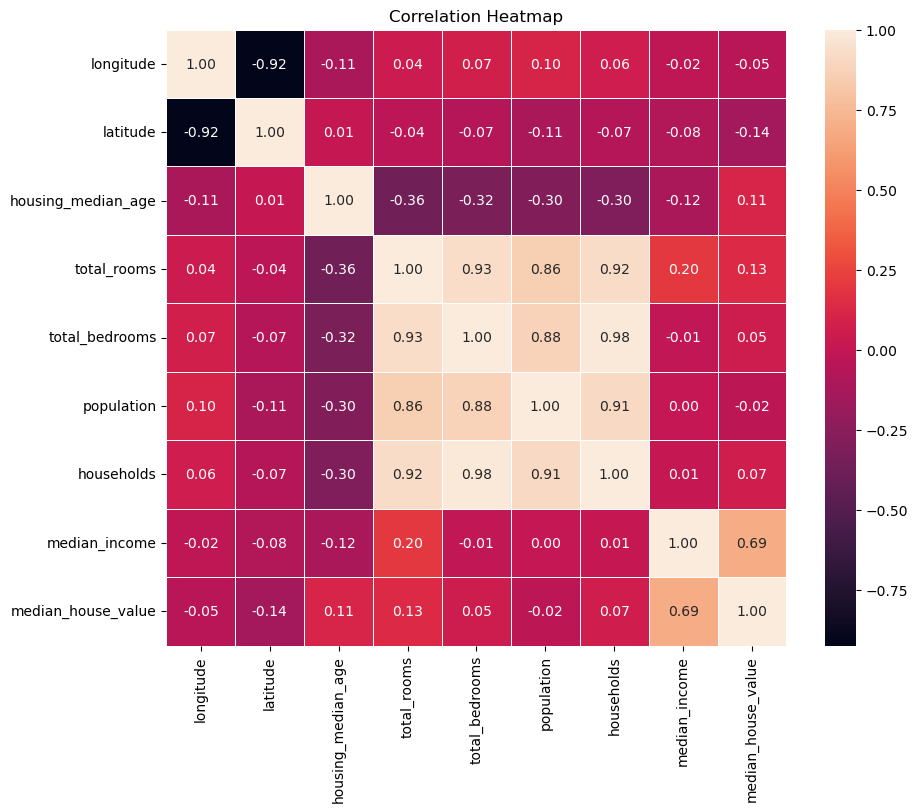

In [19]:
#determing correlation among features

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the features
correlation_matrix = df.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='rocket', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()



In [32]:
#calculating the correlation between the "median_house_value" column and all other columns
df.corr()['median_house_value'].sort_values() 

latitude             -0.144160
longitude            -0.045967
population           -0.024650
total_bedrooms        0.049686
households            0.065843
housing_median_age    0.105623
total_rooms           0.134153
median_income         0.688075
median_house_value    1.000000
Name: median_house_value, dtype: float64

#### Converting categorical data of ocean_proximity to numerical data using One hot encoding

In [20]:
#creating dummy features
ocean_proximity_numerical = pd.get_dummies(df['ocean_proximity'])

#adding the features together
df_num = pd.concat([df, ocean_proximity_numerical], axis=1)

# Dropping the original "ocean_proximity" column from the new DataFrame
df_num.drop('ocean_proximity', axis=1, inplace=True)
df_num=df_num[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
        '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY',
       'NEAR OCEAN', 'median_house_value']]
df_num.head()


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  <1H OCEAN  INLAND  ISLAND  NEAR BAY  \
0       322.0       126.0         8.3252          0       0       0         1   
1      2401.0      1138.0         8.3014          0       0       0         1   
2       496.0       177.0         7.2574          0       0       0         1   
3       558.0       219.0         5.6431          0       0       0         1   
4       565.0       259.0         3.8462          0       0       0         1   

   NEAR OCEAN  median_house_value  
0           0            452600.0  
1           0            358500.0  
2           0            352100.0  
3           0            341300.0  
4           0            342200.0

#### Handling of missing values in "total_bedrooms"

In [21]:
df[df['total_bedrooms'].isnull()].head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
290    -122.16     37.77                47.0       1256.0             NaN   
341    -122.17     37.75                38.0        992.0             NaN   
538    -122.28     37.78                29.0       5154.0             NaN   
563    -122.24     37.75                45.0        891.0             NaN   
696    -122.10     37.69                41.0        746.0             NaN   

     population  households  median_income  median_house_value ocean_proximity  
290       570.0       218.0         4.3750            161900.0        NEAR BAY  
341       732.0       259.0         1.6196             85100.0        NEAR BAY  
538      3741.0      1273.0         2.5762            173400.0        NEAR BAY  
563       384.0       146.0         4.9489            247100.0        NEAR BAY  
696       387.0       161.0         3.9063            178400.0        NEAR BAY

In [27]:
t = df_num.total_bedrooms.size
m = df_num.total_bedrooms.isna().value_counts()[True]
percentage_missing = (m / t) * 100
print("Percentage of missing values in 'total_bedrooms' is {:.3f}".format(percentage_missing))


Percentage of missing values in 'total_bedrooms' is 1.003


In [23]:
df_num['total_bedrooms'].describe()

count    20433.000000
mean       537.870553
std        421.385070
min          1.000000
25%        296.000000
50%        435.000000
75%        647.000000
max       6445.000000
Name: total_bedrooms, dtype: float64

**Here, The Mean is greater than the Median(50th percentile). So it is right skewed. In a right-skewed distribution, the mean is greater than the median. This means that the majority of the data points are concentrated on the left side of the distribution.**

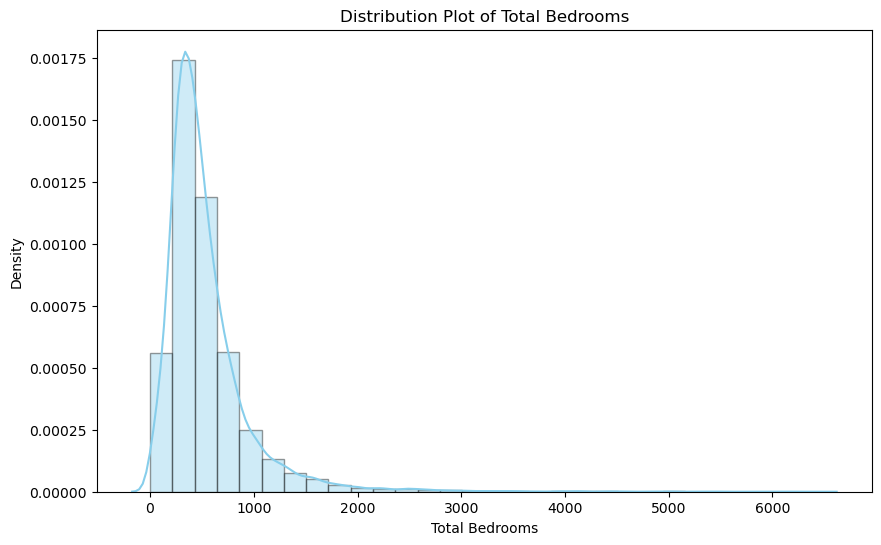

In [30]:
#plotting distribution of data in total_bedrooms
plt.figure(figsize=(10, 6))
sns.distplot(df_num['total_bedrooms'], bins=30, kde=True, color='skyblue', hist_kws={'edgecolor':'black'})
plt.xlabel('Total Bedrooms')
plt.ylabel('Density')
plt.title('Distribution Plot of Total Bedrooms')
plt.show()

In [58]:
#replacing with median
median_total_bedrooms= df_num['total_bedrooms'].median()
df_num['total_bedrooms'] = df_num['total_bedrooms'].fillna(median_total_bedrooms)
plt.figure(figsize=(6,4))
print(df_num.isnull().sum())

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
<1H OCEAN             0
INLAND                0
ISLAND                0
NEAR BAY              0
NEAR OCEAN            0
median_house_value    0
dtype: int64


<Figure size 600x400 with 0 Axes>

In [53]:
#checking for the  number of duplicate rows in the dataset
df_num.duplicated().sum()

0

#### Checking for outliers

In some cases, outliers may represent valid and meaningful data points. If the outliers are genuine and not the result of data entry errors or measurement issues, those can be kept and included in the analysis. As I am not sure about those, particularly about data generation process, I am keeping them as they are.

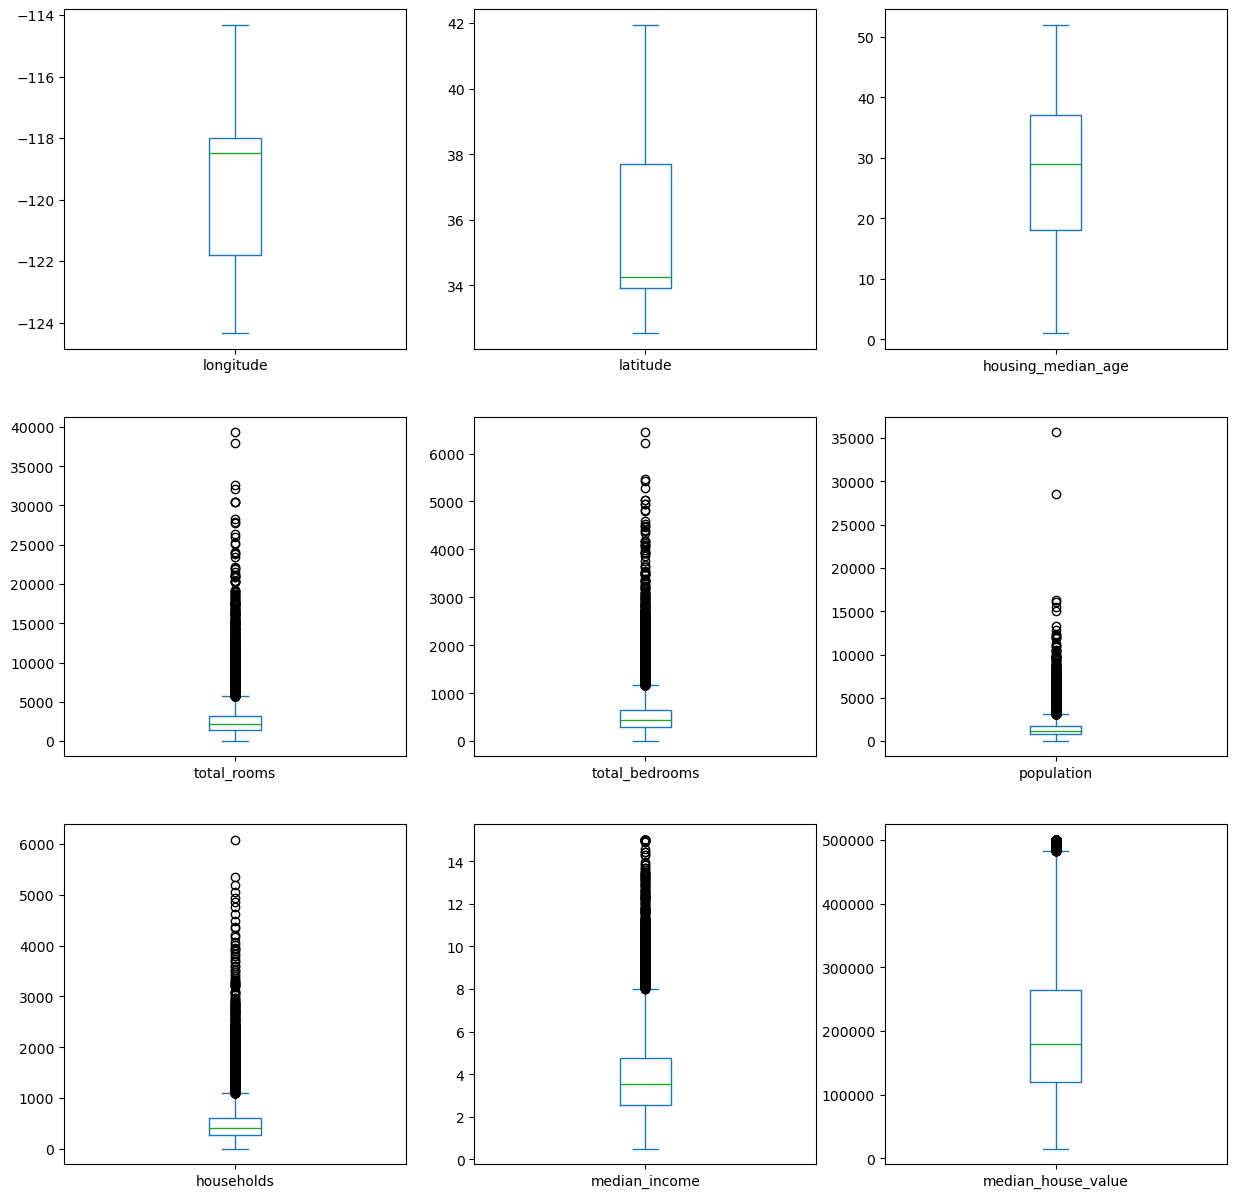

In [69]:
# Calculate the required figure size based on the desired 3x3 layout
# Selecting the desired columns (0 to 7 and the last column)
df_num.iloc[:, list(range(8)) + [-1]].plot(kind='box', subplots=True, layout=(3,3), figsize=(15,15))
plt.show()

In [76]:
# As most of outliers are important for us. Trying to see whether the data bigger than 90th percentile provide any insights or not!
percentile_90 = df_num.quantile(0.9)

# Filter the DataFrame to include only rows where specific columns are above the 90th percentile
columns_to_check = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
df_90th_percentile = df_num[df_num[columns_to_check] > percentile_90[columns_to_check]]

# Display the rows where specific columns are above the 90th percentile
print(df_90th_percentile[['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']])

       total_rooms  total_bedrooms  population  households  median_income
0              NaN             NaN         NaN         NaN         8.3252
1           7099.0          1106.0         NaN      1138.0         8.3014
2              NaN             NaN         NaN         NaN         7.2574
3              NaN             NaN         NaN         NaN            NaN
4              NaN             NaN         NaN         NaN            NaN
...            ...             ...         ...         ...            ...
20635          NaN             NaN         NaN         NaN            NaN
20636          NaN             NaN         NaN         NaN            NaN
20637          NaN             NaN         NaN         NaN            NaN
20638          NaN             NaN         NaN         NaN            NaN
20639          NaN             NaN         NaN         NaN            NaN

[20640 rows x 5 columns]


## Train-Validation-Test Set

In [101]:
#Determine the Features & Target Variable
X=df_num.drop('median_house_value',axis=1)
y=df_num['median_house_value']

In [108]:
from sklearn.model_selection import train_test_split

# Splitting the data into train and test sets (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Splitting the training data further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(13209, 13)
(13209,)
(3303, 13)
(3303,)
(4128, 13)
(4128,)


Feature scaling helps to normalize the range of the features and make them comparable, ensuring that different features do not dominate the learning process based solely on their magnitudes. Here I am using Robust Scalar as it uses the median and the interquartile range (IQR) to scale the features, making it robust to the influence of outliers.

In [111]:
from sklearn.preprocessing import RobustScaler
ro_scaler=RobustScaler()
X_train=ro_scaler.fit_transform(X_train)
X_val=ro_scaler.transform(X_val)
X_test=ro_scaler.transform(X_test)

## Building Models

Here, I will apply the following algorithms:
- Linear regression
- Ridge regression
- SVM
- K NN Regression
- Decision trees
- Adaboost
- MLP


### Linear Regression
Linear Regression does not have hyperparameters that can be tuned effectively for better result. yet, regularization techniques can be effective. 

In [185]:
# Create the Linear Regression model with default hyperparameters
linear_reg_default = LinearRegression()

# Train the model using the training data
linear_reg_default.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_val_linear_default = linear_reg_default.predict(X_val)

# Evaluate the model's performance on the validation set
mse_linear_val_default = mean_squared_error(y_val, y_pred_val_linear_default, squared=False)
r2_linear_val_default = r2_score(y_val, y_pred_val_linear_default)

In [186]:
# predictions on the test set
y_pred_test_linear_default = linear_reg_default.predict(X_test)

# Evaluating the model's performance on the test set
mse_linear_test_default = mean_squared_error(y_test, y_pred_test_linear_default, squared=False)
r2_linear_test_default = r2_score(y_test, y_pred_test_linear_default)

# Create a DataFrame to store the scores
scores_df_linear = pd.DataFrame({
    'Metric': ['Root Mean Squared Error', 'R-squared'],
    'Validation Set': [mse_linear_val_default, r2_linear_val_default],
    'Test Set': [mse_linear_test_default, r2_linear_test_default]
})

print(scores_df_linear)

                    Metric  Validation Set      Test Set
0  Root Mean Squared Error    69793.502293  70020.860473
1                R-squared        0.647016      0.625848


#### Ridge Regression: 
It is a regularized linear regression technique that adds a penalty term to the ordinary least squares (OLS) cost function to prevent overfitting and stabilize the model.

In [187]:
#Creating a Ridge Regression model
ridge_reg = Ridge()

param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(ridge_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Performing the hyperparameter tuning on the training data
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']

# Creating a new Ridge Regression model with the best hyperparameters
best_ridge_reg = Ridge(alpha=best_alpha)
best_ridge_reg.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_val_ridge = best_ridge_reg.predict(X_val)
# Evaluate the model's performance on the validation set
mse_ridge_val = mean_squared_error(y_val, y_pred_val_ridge, squared=False)
r2_ridge_val = r2_score(y_val, y_pred_val_ridge)

print("Best Alpha:", best_alpha)

Best Alpha: 0.1


In [188]:
# Make predictions on the test set
y_pred_test_ridge = best_ridge_reg.predict(X_test)

# Evaluate the model's performance on the test set
mse_ridge_test = mean_squared_error(y_test, y_pred_test_ridge, squared=False)
r2_ridge_test = r2_score(y_test, y_pred_test_ridge)

# Create a DataFrame to store the scores
scores_df_ridge = pd.DataFrame({
    'Metric': ['Root Mean Squared Error', 'R-squared'],
    'Validation Set': [mse_ridge_val, r2_ridge_val],
    'Test Set': [mse_ridge_test, r2_ridge_test]
})

print(scores_df_ridge)

                    Metric  Validation Set      Test Set
0  Root Mean Squared Error    69782.559595  70021.120930
1                R-squared        0.647127      0.625845


## SVR

In [182]:
#recording start time
start_time = time.time()

# Create an SVR model
svr_reg = SVR()

# Define the hyperparameter grid for hyperparameter tuning
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1.0, 10.0],
    'epsilon': [0.01, 0.1, 0.5],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1.0]
}

# Create a GridSearchCV object with SVR and the hyperparameter grid
grid_search = GridSearchCV(svr_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform the hyperparameter tuning on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the tuning process
best_params = grid_search.best_params_
best_kernel = best_params['kernel']
best_C = best_params['C']
best_epsilon = best_params['epsilon']
best_gamma = best_params['gamma']

# Create a new SVR model with the best hyperparameters
best_svr_reg = SVR(kernel=best_kernel, C=best_C, epsilon=best_epsilon, gamma=best_gamma)

# Train the model using the training data
best_svr_reg.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_val_svr = best_svr_reg.predict(X_val)

# Evaluate the model's performance on the validation set
mse_svr_val = mean_squared_error(y_val, y_pred_val_svr, squared=False)
r2_svr_val = r2_score(y_val, y_pred_val_svr)

# Print the best parameters found during hyperparameter tuning
print("Best Hyperparameters:", best_params)

# Print the execution time
print("It took %s seconds to execute" % (time.time() - start_time))

Best Hyperparameters: {'C': 10.0, 'epsilon': 0.5, 'gamma': 1.0, 'kernel': 'poly'}
It took 1365.0988240242004 seconds to execute


In [183]:
# Making predictions on the test set using the model with best hyperparameters
y_pred_test_svr = best_svr_reg.predict(X_test)

# to Evaluate the model's performance on the test set
mse_svr_test = mean_squared_error(y_test, y_pred_test_svr, squared=False)
r2_svr_test = r2_score(y_test, y_pred_test_svr)

# to store the scores
scores_df_svr = pd.DataFrame({
    'Metric': ['Root Mean Squared Error', 'R-squared'],
    'Validation Set': [mse_svr_val, r2_svr_val],
    'Test Set': [mse_svr_test, r2_svr_test]
})
print(scores_df_svr)

                    Metric  Validation Set      Test Set
0  Root Mean Squared Error    80132.196629  79829.201680
1                R-squared        0.534694      0.513686


## KNN

In [180]:
# Create a KNN Regression model
knn_reg = KNeighborsRegressor()

# Define the hyperparameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 10],  
    'weights': ['uniform', 'distance'],  
    'metric': ['minkowski', 'euclidean', 'manhattan'],
    'p': [1, 2, 3],
    'leaf_size': [20, 30, 40],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

# Create a GridSearchCV object with KNN Regression and the hyperparameter grid
grid_search = GridSearchCV(knn_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform the hyperparameter tuning on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the tuning process
best_params = grid_search.best_params_
best_n_neighbors = best_params['n_neighbors']
best_metric = best_params['metric']
best_weights = best_params['weights']
best_p = best_params['p']
best_leaf_size = best_params['leaf_size']
best_algorithm = best_params['algorithm']

# Create a new KNN Regression model with the best hyperparameters
best_knn_reg = KNeighborsRegressor(n_neighbors=best_n_neighbors, metric=best_metric,
                                   weights=best_weights, p=best_p,
                                   leaf_size=best_leaf_size, algorithm=best_algorithm)

# Train the model using the training data
best_knn_reg.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_val_knn = best_knn_reg.predict(X_val)

# Evaluate the model's performance on the validation set
mse_knn_val = mean_squared_error(y_val, y_pred_val_knn, squared=False)
r2_knn_val = r2_score(y_val, y_pred_val_knn)

# Print the best parameters found during hyperparameter tuning
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


In [181]:
# to make predictions on the test set using the model with best hyperparameters
y_pred_test_knn = best_knn_reg.predict(X_test)

# to evaluate the model's performance on the test set
mse_knn_test = mean_squared_error(y_test, y_pred_test_knn, squared=False)
r2_knn_test = r2_score(y_test, y_pred_test_knn)

# to store the scores
scores_df_knn = pd.DataFrame({
    'Metric': ['Root Mean Squared Error', 'R-squared'],
    'Validation Set': [mse_knn_val, r2_knn_val],
    'Test Set': [mse_knn_test, r2_knn_test]
})

print(scores_df_knn)

                    Metric  Validation Set      Test Set
0  Root Mean Squared Error    59446.597779  59133.839278
1                R-squared        0.743918      0.733151


## Decision Trees

In [178]:
start_time=time.time()
# Creating a Decision Tree regressor
dt_reg = DecisionTreeRegressor()

param_grid = {
    'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(dt_reg, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)

# Performing the hyperparameter tuning on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the tuning process
best_params = grid_search.best_params_
best_criterion = best_params['criterion']
best_splitter = best_params['splitter']
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']
best_min_samples_leaf = best_params['min_samples_leaf']

# Create a new Decision Tree Regression model with the best hyperparameters
best_dt_reg = DecisionTreeRegressor(criterion=best_criterion, splitter=best_splitter,
                                    max_depth=best_max_depth, min_samples_split=best_min_samples_split,
                                    min_samples_leaf=best_min_samples_leaf)

# Train the model using the training data
best_dt_reg.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_val_dt = best_dt_reg.predict(X_val)

# Evaluate the model's performance on the validation set
mse_dt_val = mean_squared_error(y_val, y_pred_val_dt, squared=False)
r2_dt_val = r2_score(y_val, y_pred_val_dt)

# Print the best parameters found during hyperparameter tuning
print("Best Hyperparameters:", best_params)

print("It took %s seconds to execute" % (time.time() - start_time))

Best Hyperparameters: {'criterion': 'poisson', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}
It took 269.1688938140869 seconds to execute


In [179]:
# Make predictions on the test set using the model with best hyperparameters
y_pred_test_dt = best_dt_reg.predict(X_test)

# Evaluate the model's performance on the test set
mse_dt_test = mean_squared_error(y_test, y_pred_test_dt, squared=False)
r2_dt_test = r2_score(y_test, y_pred_test_dt)

# Create a DataFrame to store the scores
scores_df_dt = pd.DataFrame({
    'Metric': ['Root Mean Squared Error', 'R-squared'],
    'Validation Set': [mse_dt_val, r2_dt_val],
    'Test Set': [mse_dt_test, r2_dt_test]
})

# Display the scores as a table
print(scores_df_dt)

                    Metric  Validation Set      Test Set
0  Root Mean Squared Error    61638.079477  60362.551481
1                R-squared        0.724689      0.721947


## AdaBoost

In [217]:
start_time=time.time()
ada_reg = AdaBoostRegressor()

param_grid = {
    'n_estimators': [50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 1.0],
    'loss': ['linear', 'square', 'exponential']
}

grid_search = GridSearchCV(ada_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the tuning process
best_params = grid_search.best_params_
best_n_estimators = best_params['n_estimators']
best_learning_rate = best_params['learning_rate']
best_loss = best_params['loss']

# Create a new AdaBoost Regressor with the best hyperparameters
best_ada_reg = AdaBoostRegressor(n_estimators=best_n_estimators, learning_rate=best_learning_rate, loss=best_loss)
best_ada_reg.fit(X_train, y_train)
y_pred_val_ada = best_ada_reg.predict(X_val)

# Evaluate the model's performance on the validation set
mse_ada_val = mean_squared_error(y_val, y_pred_val_ada, squared=False)
r2_ada_val = r2_score(y_val, y_pred_val_ada)

print("Best Hyperparameters:", best_params)
print("It took %s seconds to execute" % (time.time() - start_time))

Best Hyperparameters: {'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 250}
It took 154.49674701690674 seconds to execute


In [218]:
# predictions on the test set using the model with best hyperparameters
y_pred_test_ada = best_ada_reg.predict(X_test)

# evaluating the model's performance on the test set
mse_ada_test = mean_squared_error(y_test, y_pred_test_ada, squared=False)
r2_ada_test = r2_score(y_test, y_pred_test_ada)

scores_df_ada = pd.DataFrame({
    'Metric': ['Root Mean Squared Error', 'R-squared'],
    'Validation Set': [mse_ada_val, r2_ada_val],
    'Test Set': [mse_ada_test, r2_ada_test]
})

print(scores_df_ada)

                    Metric  Validation Set      Test Set
0  Root Mean Squared Error    74872.520369  74513.736715
1                R-squared        0.593772      0.576293


## MLP

In [259]:
# Creating an MLP Regressor with default parameters
mlp_reg = MLPRegressor(random_state=42)

# Train the model using the training data
mlp_reg.fit(X_train, y_train)

y_pred_val_mlp = mlp_reg.predict(X_val)
mse_mlp_val = mean_squared_error(y_val, y_pred_val_mlp, squared=False)
r2_mlp_val = r2_score(y_val, y_pred_val_mlp)

y_pred_test_mlp = mlp_reg.predict(X_test)
mse_mlp_test = mean_squared_error(y_test, y_pred_test_mlp, squared=False)
r2_mlp_test = r2_score(y_test, y_pred_test_mlp)

scores_df_mlp = pd.DataFrame({
    'Metric': ['Root Mean Squared Error', 'R-squared'],
    'Validation Set': [mse_mlp_val, r2_mlp_val],
    'Test Set': [mse_mlp_test, r2_mlp_test]
})

print(scores_df_mlp)


                    Metric  Validation Set       Test Set
0  Root Mean Squared Error   182942.144794  180247.468063
1                R-squared       -1.425226      -1.479314


A negative R-squared value indicates that the model's predictions are worse than simply using the mean of the target variable to make predictions. This can happen when the model is a poor fit to the data or when it is overfitting.

#### Sequential Model
Sequential model in Keras is a linear stack of layers, and it is a convenient way to build feedforward neural networks. An MLP is a type of sequential model. Since an MLP can be represented as a linear stack of layers, it naturally fits the concept of a Sequential model in Keras. In Keras, One can use the Sequential class to build an MLP by adding layers to it one after the other. This allows to define the architecture of the network in a sequential manner, which is simple and intuitive.

Here I will use the following layer structure: The model is a simple feedforward neural network with 3 hidden layers. The number of units in each layer can be adjusted based on the complexity of the problem and the characteristics of the data.

- The input layer has 50 units.
- The first hidden layer has 100 units, and the second hidden layer has 50 units, both using the ReLU activation function.
- The output layer has a single unit for regression, with a linear activation function.


In [282]:
from keras.models import Sequential
from keras.layers import Dense

# Create a Sequential model
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(50, activation='relu', input_shape=X_train.shape[1:]))

# Adding more hidden layers
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))

# Adding the output layer
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# Evaluating the model on the test set

y_pred_test = model.predict(X_test)
loss, mse, mae = model.evaluate(X_test, y_test)
print("Mean Squared Error on Test Set:", mse)
print("Mean Absolute Error on Test Set:", mae)

# Calculate R-squared value
r2_seq_test = r2_score(y_test, y_pred_test)

# Calculate RMSE
rmse_seq_test = mean_squared_error(y_test, y_pred_test, squared=False)

print("Root Mean Squared Error on Test Set:", rmse_seq_test)
print("R-squared on Test Set:", r2_seq_test)


Epoch 1/100
413/413 [==============================] - 1s 980us/step - loss: 43447459840.0000 - mse: 43447459840.0000 - mae: 173044.1719 - val_loss: 16973500416.0000 - val_mse: 16973500416.0000 - val_mae: 97719.8516
Epoch 2/100
413/413 [==============================] - 0s 759us/step - loss: 10075553792.0000 - mse: 10075553792.0000 - mae: 71041.5469 - val_loss: 7147872256.0000 - val_mse: 7147872256.0000 - val_mae: 59708.4102
Epoch 3/100
413/413 [==============================] - 0s 765us/step - loss: 5936058880.0000 - mse: 5936058880.0000 - mae: 54454.5508 - val_loss: 5568494592.0000 - val_mse: 5568494592.0000 - val_mae: 53554.3438
Epoch 4/100
413/413 [==============================] - 0s 777us/step - loss: 5115016704.0000 - mse: 5115016704.0000 - mae: 51253.4023 - val_loss: 5153403904.0000 - val_mse: 5153403904.0000 - val_mae: 52299.2734
Epoch 5/100
413/413 [==============================] - 0s 771us/step - loss: 4849122304.0000 - mse: 4849122304.0000 - mae: 50213.2031 - val_loss: 498

## XGBoost

In [215]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
start_time = time.time()

xgb_reg = xgb.XGBRegressor()

param_grid = {
    'n_estimators': [50, 100, 150, 200],  
    'learning_rate': [0.01, 0.05, 0.1, 0.5],  
    'max_depth': [3, 5, 7],  
    'subsample': [0.8, 0.9, 1.0],  
    'colsample_bytree': [0.8, 0.9, 1.0] 
}

# Create a GridSearchCV object with XGBoost Regressor and the hyperparameter grid
grid_search = GridSearchCV(xgb_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform the hyperparameter tuning on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the tuning process
best_params = grid_search.best_params_
best_n_estimators = best_params['n_estimators']
best_learning_rate = best_params['learning_rate']
best_max_depth = best_params['max_depth']
best_subsample = best_params['subsample']
best_colsample_bytree = best_params['colsample_bytree']

# Create a new XGBoost Regressor with the best hyperparameters
best_xgb_reg = xgb.XGBRegressor(n_estimators=best_n_estimators, learning_rate=best_learning_rate,
                                max_depth=best_max_depth, subsample=best_subsample,
                                colsample_bytree=best_colsample_bytree)

# Train the model using the training data
best_xgb_reg.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_val_xgb = best_xgb_reg.predict(X_val)

# Evaluate the model's performance on the validation set
mse_xgb_val = mean_squared_error(y_val, y_pred_val_xgb, squared=False)
r2_xgb_val = r2_score(y_val, y_pred_val_xgb)

print("Best Hyperparameters:", best_params)
print("It took %s seconds to execute" % (time.time() - start_time))

Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.9}
It took 705.8281388282776 seconds to execute


In [216]:
# predictions on the test set using the model with best hyperparameters
y_pred_test_xgb = best_xgb_reg.predict(X_test)

# evaluating the model's performance on the test set
mse_xgb_test = mean_squared_error(y_test, y_pred_test_xgb, squared=False)
r2_xgb_test = r2_score(y_test, y_pred_test_xgb)

scores_df_xgb = pd.DataFrame({
    'Metric': ['Root Mean Squared Error', 'R-squared'],
    'Validation Set': [mse_xgb_val, r2_xgb_val],
    'Test Set': [mse_xgb_test, r2_xgb_test]
})

print(scores_df_xgb)

                    Metric  Validation Set      Test Set
0  Root Mean Squared Error    48452.541943  46217.383609
1                R-squared        0.829879      0.836994


## Comparison of the results

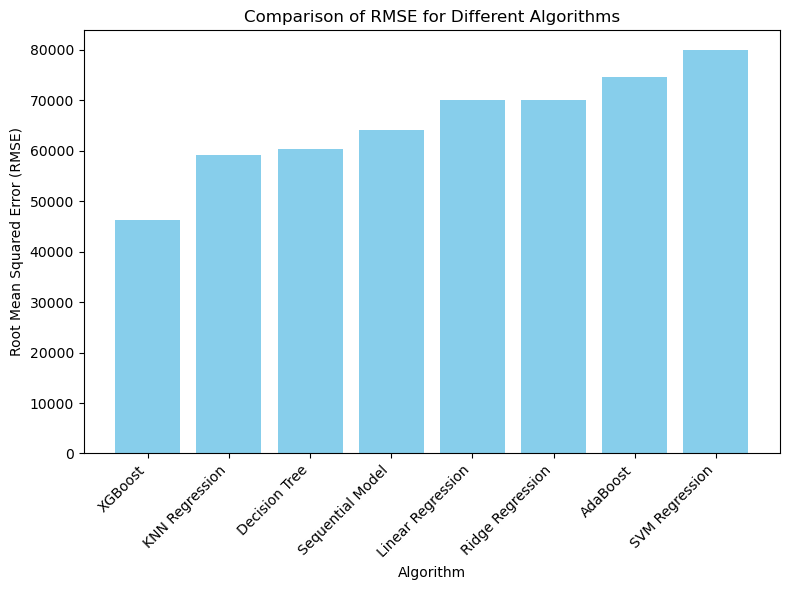

In [291]:
test_scores_df = pd.DataFrame({
    'Algorithm': ['Linear Regression', 'Ridge Regression', 'KNN Regression',
                  'Decision Tree', 'SVM Regression', 'AdaBoost','Sequential Model', 'XGBoost'],
    'RMSE': [mse_linear_test_default, mse_ridge_test, mse_knn_test,
                  mse_dt_test, mse_svr_test, mse_ada_test, rmse_seq_test, mse_xgb_test]
})

# Sort the DataFrame based on Test RMSE in ascending order
test_scores_df = test_scores_df.sort_values(by='RMSE')

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(test_scores_df['Algorithm'], test_scores_df['RMSE'], color='skyblue')
plt.xlabel('Algorithm')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Comparison of RMSE for Different Algorithms')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [286]:
test_scores_df

Algorithm          RMSE
7            XGBoost  46217.383609
2     KNN Regression  59133.839278
3      Decision Tree  60362.551481
6   Sequential Model  63995.289662
0  Linear Regression  70020.860473
1   Ridge Regression  70021.120930
5           AdaBoost  74513.736715
4     SVM Regression  79829.201680

For RMSE, a smaller value is better. So, here, XGBoost performed better.

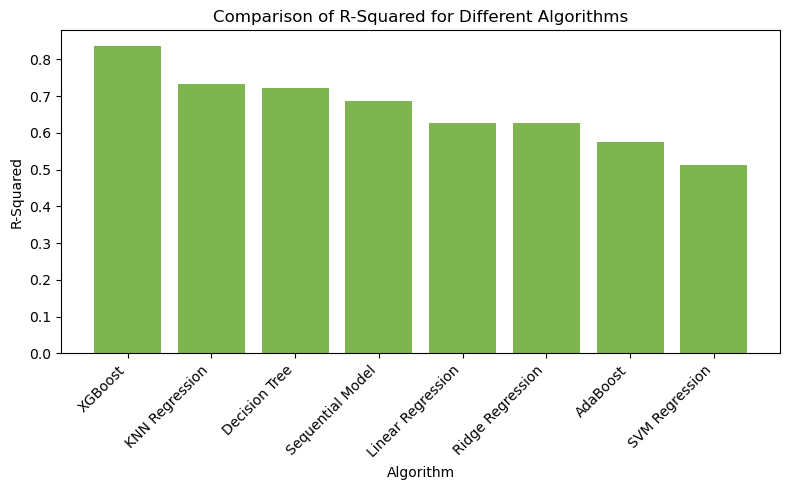

In [287]:
test_scores_df_r2 = pd.DataFrame({
    'Algorithm': ['Linear Regression', 'Ridge Regression', 'KNN Regression',
                  'Decision Tree', 'SVM Regression', 'AdaBoost','Sequential Model', 'XGBoost'],
    'R_Squared': [r2_linear_test_default, r2_ridge_test, r2_knn_test,
                  r2_dt_test, r2_svr_test, r2_ada_test, r2_seq_test, r2_xgb_test]
})

# Sort the DataFrame based on Test RMSE in ascending order
test_scores_df_r2 = test_scores_df_r2.sort_values(by='R_Squared', ascending=False)

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(test_scores_df_r2['Algorithm'], test_scores_df_r2['R_Squared'], color='#7eb54e')
plt.xlabel('Algorithm')
plt.ylabel('R-Squared')
plt.title('Comparison of R-Squared for Different Algorithms')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [288]:
test_scores_df_r2

Algorithm  R_Squared
7            XGBoost   0.836994
2     KNN Regression   0.733151
3      Decision Tree   0.721947
6   Sequential Model   0.687472
0  Linear Regression   0.625848
1   Ridge Regression   0.625845
5           AdaBoost   0.576293
4     SVM Regression   0.513686

For R-squared, a larger value is better. So, here, XGBoost performed better.

# Regression Task on 'California Housing Prices' Dataset -Summary

This repository contains code for applying regression techniques on the 'California Housing Prices' dataset after performing EDA and data preprocessing. The goal is to build regression models to predict house prices based on the given features.

## Dataset

The data pertains to the houses found in a given California district and some summary stats about them based on the 1990 census data.
The 'California Housing Prices' dataset contains housing data for various districts in California. It has the following features:

- longitude: A measure of how far west a house is; a higher value is farther west
- latitude: A measure of how far north a house is; a higher value is farther north
- housingMedianAge: Median age of a house within a block; a lower number is a newer building
- totalRooms: Total number of rooms within a block
- totalBedrooms: Total number of bedrooms within a block
- population: Total number of people residing within a block
- households: Total number of households, a group of people residing within a home unit, for a block
- medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
- medianHouseValue: Median house value for households within a block (measured in US Dollars)
- oceanProximity: Location of the house w.r.t ocean/sea

## Workflow

1. **Data Preprocessing and EDA**: 

The dataset is loaded and being analyzed. There are 20640 data with 10 features. All except the 'ocean_proximity' feature have numerical data. I used one hot encoding, a technique to represent categorical variables as numerical values in a  machine learning model. I have observed that there are 207 null values in 'total_bedrooms' feature. I handled the missing values using median.

In 'total_bedrooms' feature, I have observed that the Mean is greater than the Median(50th percentile). It means that it is right skewed. This explains that the majority of the data points are concentrated on the left side of the distribution. Hence, I chose median.

There are also some outliers on the dataset. Outliers may represent valid and meaningful data points in some cases. If the outliers are genuine and not the result of data entry errors or measurement issues, those can be kept and included in the analysis. As I am not sure about those, particularly about data generation process, I kept them as they are.

I have also done feature scaling on the data. Feature scaling helps to normalize the range of the features and make them comparable, ensuring that different features do not dominate the learning process based solely on their magnitudes. Here I used Robust Scalar as it uses the median and the interquartile range (IQR) to scale the features, making it more robust and resistant to the influence of outliers compared to StandardScaler.

2. **Splitting the dataset**:

The dataset is split in a 80-20 ratio for training and testing, and then the training data is further divided into a training set and a validation set in a 80-20 ratio. After fitting the training dataset, I used validation dataset for initial testing and experimenting parameter tuning. I used the test set for final prediction result.

3. **Regression Models**: 

I have used the following algorithms. I have provided brief background details of each technique I used :

* **Linear Regression**:
Linear regression is a simple and widely used regression algorithm that models the relationship between the dependent variable and one or more independent variables by fitting a linear equation to the data. It works well when the relationship between the features and the target variable is linear. Linear regression can be prone to overfitting if there are too many features or multicollinearity among the features.

* **Ridge Regression**:
Ridge regression is a linear regression technique that incorporates L2 regularization to address multicollinearity issues and prevent overfitting. It adds a penalty term to the linear regression cost function that includes the squared values of the coefficients. The regularization term helps to shrink the coefficients, effectively reducing the impact of less important features on the model. Ridge regression is suitable when there are highly correlated features in the dataset, and it provides more stable and interpretable results compared to standard linear regression.

* **Support Vector Regression (SVR)**:
SVR is a regression algorithm based on Support Vector Machines (SVM) that aims to find the best hyperplane that maximizes the margin while allowing for some tolerance for errors (epsilon-insensitive loss). SVR is particularly effective when dealing with non-linear relationships between features and the target variable. It transforms the input data into a higher-dimensional space using a kernel function and finds the optimal hyperplane in that space. SVR can handle both linear and non-linear regression tasks and is robust to outliers.

* **K-Nearest Neighbors (KNN) Regression**:
KNN regression is a non-parametric algorithm that predicts the target value by averaging the values of its k nearest neighbors in the feature space. KNN is simple and easy to understand, making no assumptions about the underlying data distribution. However, it can be sensitive to the choice of k, and the prediction time can be computationally expensive for large datasets. KNN regression performs well when the data has local patterns, and there is no clear linear relationship between features and the target variable.

* **Decision Tree Regression**:
Decision tree regression is a non-linear algorithm that models the target variable by recursively splitting the feature space into subsets based on the most informative features. Each split creates a node in the tree, and the predicted value for a new sample is the average of the target values in the leaf node that the sample falls into. Decision tree regression is interpretable and can handle both numerical and categorical features. However, it tends to overfit the training data when the tree depth is not controlled.

* **AdaBoost Regression**:
AdaBoost stands for Adaptive Boosting, and AdaBoost regression is an ensemble method that combines multiple weak learners (typically decision trees) to create a strong predictor. The weak learners are trained sequentially, and each subsequent model focuses on correcting the errors made by the previous ones. AdaBoost assigns weights to each sample, emphasizing misclassified samples during each training iteration. It is effective in reducing bias and variance and performs well when the weak learners complement each other.

* **XGBoost Regression**:
XGBoost (Extreme Gradient Boosting) is an advanced ensemble method based on gradient boosting. It uses gradient-based optimization techniques and regularization to achieve high accuracy and computational efficiency. XGBoost builds a sequence of decision trees and combines their predictions to make the final prediction. It incorporates various hyperparameter tuning options, making it highly customizable and powerful. XGBoost is widely used in competitions and real-world applications due to its performance and versatility.

* **Multi-Layer Perceptron (MLP) Regression and Sequential Model**:
Multi-Layer Perceptron (MLP) Regression: MLP is a type of artificial neural network that consists of multiple layers of interconnected nodes (neurons). The input is passed through the hidden layers, and each neuron applies an activation function to its input. MLP regression can learn complex non-linear relationships between features and the target variable. It uses backpropagation and optimization algorithms to adjust the weights during training to minimize the error between actual and predicted values. MLP regression is flexible and capable of handling large-scale data and complex tasks, but it requires careful tuning and may suffer from overfitting without appropriate regularization. It is type of sequential model. In Keras, a Sequential model is a linear stack of layers, where you can simply add one layer at a time. A Sequential model is a suitable choice for feedforward neural networks, where the data flows sequentially through the layers from the input to the output. Each layer in the model has weights that are learned during training. On the other hand, a MLP is a type of feedforward neural network, which consists of multiple layers of interconnected nodes (neurons). An MLP can be represented as a sequence of layers, where each layer connects to the next one in a linear manner. The input to each neuron in a layer is the output from the previous layer. Since an MLP can be represented as a linear stack of layers, it naturally fits the concept of a Sequential model in Keras. In Keras, One can use the Sequential class to build an MLP by adding layers to it one after the other. This allows to define the architecture of the network in a sequential manner, which is simple and intuitive.

4. **Evaluation Metrics**:

For evaluation, I have used RMSE (Root Mean Squared Error) and R-squared (Coefficient of Determination). 

RMSE measures the average magnitude of the error (residuals) made by the model in predicting the target values. It represents the square root of the average of squared differences between the predicted values and the actual target values. Smaller RMSE values indicate that the model's predictions are closer to the actual values, and hence, a smaller RMSE is better.

R-squared represents the proportion of the variance in the target variable that is explained by the model. Larger R-squared values suggest that the model is better at explaining the variation in the target variable and hence, a larger R-squared is better.


5. **Result**

| Algorithm         | RMSE           | R-squared      |
|-------------------|----------------|----------------|
| XGBoost           | 46217.383609   | 0.836994       |
| KNN Regression    | 59133.839278   | 0.733151       |
| Decision Tree     | 60362.551481   | 0.721947       |
| Sequential Model  | 63995.289662   | 0.687472       |
| Linear Regression | 70020.860473   | 0.625848       |
| Ridge Regression  | 70021.120930   | 0.625845       |
| AdaBoost          | 74513.736715   | 0.576293       |
| SVM Regression    | 79829.201680   | 0.513686       |

For RMSE, a smaller value is better, while for R-squared, a larger value is better. So, here, XGBoost performed better.


## Conclusion

In conclusion, XGBoost demonstrated the best performance in predicting California housing prices, providing the lowest RMSE and the highest R-squared value. The results highlight the effectiveness of XGBoost as a powerful regression algorithm for this particular dataset. Further optimization and fine-tuning of hyperparameters may improve the performance of other models. Generally, the best technique to use for a specific regression problem will depend on the following factors:

- The complexity of the relationship between the features and the target variable
- The amount of data available
- The desired accuracy of the predictions

Sometimes in industry, combination of algorithms are used for better performance.



